In [1]:
import pandas as pd
import numpy as np
import glob
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../scripts')

import plot_utils
import spatial_utils

In [295]:
q90_df = pd.read_csv('../processed_data/q90_min_periph_dists.csv')
q90_df.head()

,global_x,global_y,global_z,target_molecule_name,num_assigned_cells,cell_id,sample,min_boundary_dist,clust_id,rank,cell_spot_num,normalized_rank
0,-4237.7397,1681.8490,0.0,Acta2,1,217951229059897556843731256135790480948,mouse1sample2,4.981020,2,1128.0,1256.0,0.898089
1,-4215.4233,1699.2443,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,1.670875,2,502.0,1216.0,0.412829
2,-4207.3945,1706.8620,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,5.015634,2,1144.0,1216.0,0.940789
3,-4206.7200,1711.7010,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,0.636409,2,151.0,1216.0,0.124178
4,-4270.8410,1726.0154,0.0,Acta2,1,29559620824861669263446897425219499530,mouse1sample2,3.183747,2,686.0,852.0,0.805164


In [303]:
per_cell_gene = q90_df.groupby(['cell_id','target_molecule_name']).agg(
    num_gene_spots = ('rank','count'),
    per_cell_median_periph = ('normalized_rank','median'),
).reset_index()
per_cell_gene.head()

,cell_id,target_molecule_name,num_gene_spots,per_cell_median_periph
0,100024126192764500990464846159908804485,1700022I11Rik,1,0.048751
1,100024126192764500990464846159908804485,Acta2,4,0.894768
2,100024126192764500990464846159908804485,Adam2,1,0.752675
3,100024126192764500990464846159908804485,Adamts4,1,0.859691
4,100024126192764500990464846159908804485,Adra1b,26,0.325208


In [305]:
per_gene = per_cell_gene.groupby('target_molecule_name').agg(
    num_cells = ('cell_id', lambda g: g.unique().size),
    median_gene_spots_per_cell = ('num_gene_spots', 'median'),
    obs_med_periph = ('per_cell_median_periph', 'median'),
).sort_values('obs_med_periph')

per_gene

,num_cells,median_gene_spots_per_cell,obs_med_periph
target_molecule_name,,,
Cxcl14,17211,2,0.282680
Gfap,8073,1,0.307045
Flt1,4728,1,0.314840
Timp3,13157,2,0.321353
Aqp4,14779,2,0.333333
...,...,...,...
1810046K07Rik,7312,1,0.735475
Chrna2,13132,1,0.739055
Corin,6845,1,0.742479


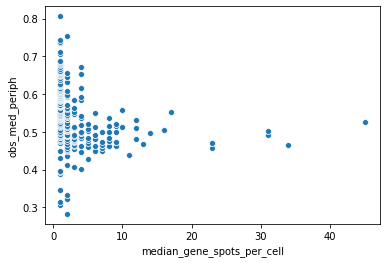

In [309]:
sns.scatterplot(
    x = 'median_gene_spots_per_cell',
    y = 'obs_med_periph',
    data = per_gene,
)
plt.show()
plt.close()

# Doing per-cluster analysis now

In [4]:
q90_df['gene_spot_num'] = (
    q90_df.groupby(['cell_id','target_molecule_name'])
    ['cell_id']
    .transform('count')
)

per_clust_gene_obs = (
    q90_df.groupby(['clust_id','target_molecule_name'])
    .agg(
        num_cells = ('cell_id', lambda g: g.unique().size),
        median_cluster_periph = ('normalized_rank', 'median'),
        median_spots_per_cell = ('gene_spot_num', 'median')
    )
    .reset_index()
)
per_clust_gene_obs.head()

,clust_id,target_molecule_name,num_cells,median_cluster_periph,median_spots_per_cell
0,0,1700022I11Rik,68,0.634946,1.0
1,0,1810046K07Rik,275,0.712142,1.0
2,0,5031425F14Rik,106,0.710038,1.0
3,0,5730522E02Rik,167,0.702632,1.0
4,0,Acta2,593,0.431034,3.0


In [8]:
filt_per_clust_gene_obs = per_clust_gene_obs[
    per_clust_gene_obs['median_spots_per_cell'].ge(3) &
    per_clust_gene_obs['num_cells'].ge(10)
]

filt_per_clust_gene_obs['target_molecule_name'].unique().size

221

In [9]:
filt_per_clust_gene_obs.sort_values('median_cluster_periph')

,clust_id,target_molecule_name,num_cells,median_cluster_periph,median_spots_per_cell
4692,22,Cldn5,25,0.102804,4.0
7172,32,Gfap,23,0.115897,7.0
7086,32,Aqp4,26,0.150463,3.0
1770,7,Flt1,87,0.161000,5.0
7303,32,Timp3,28,0.163395,4.0
...,...,...,...,...,...
3227,14,Col24a1,765,0.822023,8.0
4195,20,Col24a1,294,0.832811,8.0
5455,25,Col24a1,193,0.840244,12.0
6659,30,Col24a1,519,0.846235,20.0


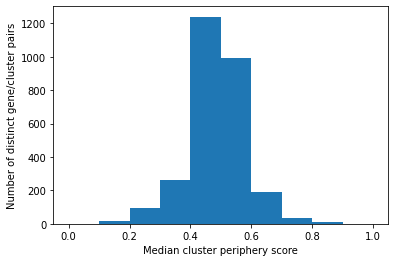

In [12]:
filt_per_clust_gene_obs['median_cluster_periph'].plot.hist(bins = np.arange(0,1.1,0.1))
plt.xlabel('Median cluster periphery score')
plt.ylabel('Number of distinct gene/cluster pairs')
plt.show()
plt.close()

In [15]:
filt_per_clust_gene_obs['std'] = (
    filt_per_clust_gene_obs.groupby('target_molecule_name')
    ['median_cluster_periph']
    .transform('std')
)

filt_per_clust_gene_obs.head()

,clust_id,target_molecule_name,num_cells,median_cluster_periph,median_spots_per_cell,std
4,0,Acta2,593,0.431034,3.0,0.059933
8,0,Adra1b,653,0.462865,9.0,0.030613
10,0,Ankfn1,233,0.614980,5.0,0.023306
11,0,Ano4,484,0.569839,3.0,0.039445
12,0,Aqp4,540,0.292058,3.0,0.094341


In [17]:
filt_per_clust_gene_obs.sort_values('std',ascending=False).drop_duplicates('target_molecule_name')

,clust_id,target_molecule_name,num_cells,median_cluster_periph,median_spots_per_cell,std
2464,10,Cldn5,21,0.197486,6.0,0.150990
2217,9,Col15a1,1205,0.792503,5.0,0.148365
3743,17,Timp3,11,0.557201,13.0,0.122473
4957,23,Cspg4,49,0.396764,3.0,0.114292
466,1,Sox10,160,0.285906,3.0,0.106875
...,...,...,...,...,...,...
5214,24,Dmkn,79,0.520522,3.0,NaN
5402,25,B4galnt3,267,0.636877,3.0,NaN
6629,30,Car3,453,0.513018,4.0,NaN
7130,32,Chodl,45,0.552055,23.0,NaN


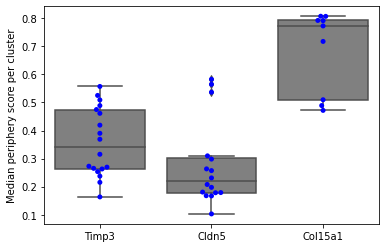

In [21]:
plot_df = filt_per_clust_gene_obs[
    filt_per_clust_gene_obs['target_molecule_name'].isin([
        'Cldn5',
        'Col15a1',
        'Timp3',
    ])
]

sns.boxplot(
    x = 'target_molecule_name',
    y = 'median_cluster_periph',
    color = 'grey',
    data = plot_df,
)

sns.swarmplot(
    x = 'target_molecule_name',
    y = 'median_cluster_periph',
    color = 'blue',
    data = plot_df,
)
plt.xlabel('')
plt.ylabel('Median periphery score per cluster')
plt.show()
plt.close()

In [24]:
filt_per_clust_gene_obs[filt_per_clust_gene_obs['target_molecule_name'].eq('Cldn5')].sort_values('median_cluster_periph')

,clust_id,target_molecule_name,num_cells,median_cluster_periph,median_spots_per_cell,std
4692,22,Cldn5,25,0.102804,4.0,0.15099
6400,29,Cldn5,48,0.166956,5.0,0.15099
4440,21,Cldn5,95,0.167694,5.0,0.15099
3220,14,Cldn5,246,0.178265,5.0,0.15099
1008,4,Cldn5,399,0.178862,4.0,0.15099
5951,27,Cldn5,42,0.180599,5.0,0.15099
2464,10,Cldn5,21,0.197486,6.0,0.15099
1485,6,Cldn5,430,0.207763,4.0,0.15099
2968,12,Cldn5,370,0.231173,3.0,0.15099
5448,25,Cldn5,59,0.257181,4.0,0.15099


In [25]:
filt_per_clust_gene_obs[filt_per_clust_gene_obs['target_molecule_name'].eq('Col15a1')].sort_values('median_cluster_periph')

,clust_id,target_molecule_name,num_cells,median_cluster_periph,median_spots_per_cell,std
1254,5,Col15a1,14,0.471898,29.0,0.148365
5704,26,Col15a1,94,0.489094,21.0,0.148365
2721,11,Col15a1,77,0.509753,24.0,0.148365
4445,21,Col15a1,369,0.717686,3.0,0.148365
4949,23,Col15a1,226,0.772926,27.0,0.148365
4193,20,Col15a1,250,0.791582,4.0,0.148365
2217,9,Col15a1,1205,0.792503,5.0,0.148365
1490,6,Col15a1,2343,0.807018,8.0,0.148365
5453,25,Col15a1,409,0.807447,7.0,0.148365


In [26]:
filt_per_clust_gene_obs[filt_per_clust_gene_obs['target_molecule_name'].eq('Timp3')].sort_values('median_cluster_periph')

,clust_id,target_molecule_name,num_cells,median_cluster_periph,median_spots_per_cell,std
7303,32,Timp3,28,0.163395,4.0,0.122473
4358,20,Timp3,150,0.215385,3.0,0.122473
6822,30,Timp3,278,0.237515,3.0,0.122473
1655,6,Timp3,1582,0.253583,3.0,0.122473
2131,8,Timp3,15,0.263033,7.0,0.122473
1178,4,Timp3,1960,0.265241,3.0,0.122473
3390,14,Timp3,993,0.269511,3.0,0.122473
231,0,Timp3,441,0.272813,3.0,0.122473
5366,24,Timp3,85,0.315426,4.0,0.122473
2634,10,Timp3,64,0.368977,4.0,0.122473


In [58]:
filt_per_clust_gene_obs.to_csv('../processed_data/20210201_filtered_per_gene_per_cluster_obs_periph.csv',index=False)

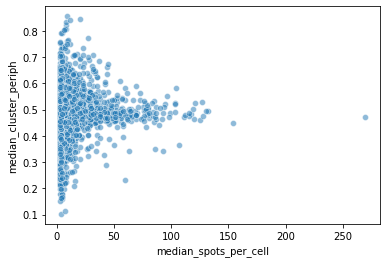

In [27]:
sns.scatterplot(
    x = 'median_spots_per_cell',
    y = 'median_cluster_periph',
    alpha = 0.5,
    data = filt_per_clust_gene_obs,
)

plt.show()
plt.close()

# Simulating different cell/gene compositions

I think that the periphery metric is sensitive to the fraction of gene spots in a cell

If a gene is 100% of the spots in a cell, then it will necessarily have a periphery score of 0.5

If it is a single spot in a cell, however, then it is possible for it to range from 1/n all the way to 1

In fact, there are hard limits on what range of periphery scores a gene can achieve in a cell based exclusively on the number of spots of that gene

One thing to note before I go into this, I'm not normalizing the ranks correctly. A periphery score of 0 is not possible because I'm ranking the most peripheral spot to be "1" instead of "0"

Ignoring that, here is a table of possible scores from number of gene spots, and then I'll try and generalize

In [45]:
n = 100
step = 1/n

data = {
    'num_spots':[1,2,3,4,],
    'min_score':[0,(0+(0+step))/2, (0+(0+step)+(0+2*step))/3, (0+(0+step)+(0+2*step)+(0+3*step))/4],
    'max_score':[1,(1+(1-step))/2, (1+(1-step)+(1-2*step))/3, (1+(1-step)+(1-2*step)+(1-3*step))/4],
}

pd.DataFrame(data)

,num_spots,min_score,max_score
0,1,0.000,1.000
1,2,0.005,0.995
2,3,0.010,0.990
3,4,0.015,0.985


so it looks like there is a shrinking envelope of possible scores that shrinks by 1/n for each additional gene spot

wait, but it has to level out, and I wasn't expecting it to decrease linearly

In [41]:
q90_df['normalized_rank'].min()

0.00040112314480545525

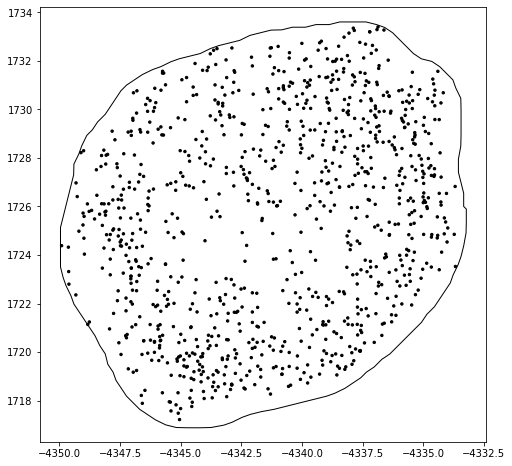

In [33]:
cell_id = '236544133250884027596792000693618583801'

cell_spots = q90_df[q90_df['cell_id'].eq(cell_id)]

plots = plot_utils.plot_spot_cells(cell_spots,cells_df)
for fig,ax in plots:
    plt.show()
    plt.close()

In [34]:
cell_spots['target_molecule_name'].value_counts()

Slc30a3     71
Wipf3       62
Camk2d      54
Cdh13       53
Trp53i11    49
            ..
Prss23       1
Sulf1        1
Tshz2        1
Ptger3       1
Ptprm        1
Name: target_molecule_name, Length: 130, dtype: int64

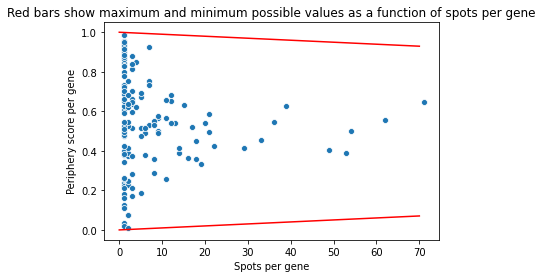

In [55]:
plot_df = cell_spots.groupby(['target_molecule_name','gene_spot_num'])['normalized_rank'].median().reset_index()

sns.scatterplot(
    x = 'gene_spot_num',
    y = 'normalized_rank',
    data = plot_df,
)

n = plot_df['gene_spot_num'].sum()
step = 1/n
max_gene_spots = plot_df['gene_spot_num'].max()

xs = range(max_gene_spots)
min_vs = [step*x for x in xs]
max_vs = [1-step*x for x in xs]

plt.plot(xs,min_vs,color='red',)
plt.plot(xs,max_vs,color='red',)

plt.title('Red bars show maximum and minimum possible values as a function of spots per gene')
plt.xlabel('Spots per gene')
plt.ylabel('Periphery score per gene')
plt.show()
plt.close()

# Calculating the probability that each value is a median in a test case


In [11]:
round(6.5)

6

In [72]:
n = 11
k = 3
print(n,k)
its = 1000

meds = []

for i in range(its):
    vals = np.random.choice(range(n),k,replace=False)/(n-1)
    meds.append(np.median(vals))
    
u = np.mean(meds)
v = np.var(meds)
print(u,v)

11 3
0.49620000000000003 0.04984555999999999


In [60]:
pd.DataFrame(meds)[0].value_counts()

0.55    114
0.50    100
0.35     90
0.40     62
0.45     61
0.25     60
0.65     59
0.70     59
0.75     59
0.60     58
0.65     48
0.45     38
0.30     32
0.85     29
0.60     29
0.15     26
0.80     23
0.20     22
0.30     19
0.40     12
Name: 0, dtype: int64

In [62]:
n = 11
np.arange(0.5,n+0.5,0.5)

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ])

In [102]:
import scipy.misc

def calc_mean_var_odd_k(n,k):
    possible_meds = np.arange(1,n+1)
    num_ways = {}

    for x in range(n):
        num_flank_each_side = k // 2 # if k = 5, then _ _ x _ _ two flank each side
        num_ways[x] = scipy.special.comb(x-1,num_flank_each_side)*scipy.special.comb(n-x,num_flank_each_side)

    total_ways = scipy.special.comb(n,k)
    probs = {((k-1)/(n-1)):(v/total_ways) for k,v in num_ways.items()}
    expected_value = sum(k*v for k,v in probs.items())
    var = sum(v*(k**2) for k,v in probs.items())-(expected_value**2)
    return expected_value,var,probs

    
def calc_mean_var_even_k(n,k):
    possible_meds = np.arange(0.5,n,0.5)
    
    
    
    expected_value = None
    var = None
    
    probs = (possible_meds-0.5)/(n-1)
    return expected_value,var,probs


def calc_mean_var(n,k):
    if k%2 == 1:
        return calc_mean_var_odd_k(n,k)
    else:
        return calc_mean_var_even_k(n,k)
        

n = 11
ks = [4]


meds,vs,probs = zip(*[calc_mean_var(n,k) for k in ks])
meds = np.array(meds)
vs = np.array(vs)

print(meds)
print(vs)

[None]
[None]


In [34]:
scipy.special.comb(12, 4)

495.0

In [82]:
len(probs[0])

23

In [103]:
probs

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),)

0.2323850795939849

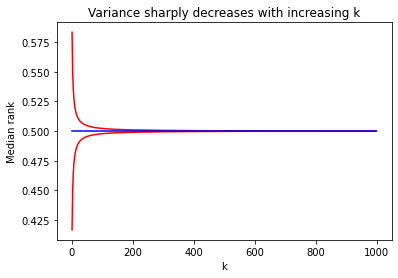

In [293]:
plt.plot(ks,meds-vs,color='r')
plt.plot(ks,meds+vs,color='r')
plt.plot(ks,meds,color='b')
plt.title('Variance sharply decreases with increasing k')
plt.xlabel('k')
plt.ylabel('Median rank')
plt.show()
plt.close()

In [236]:
(np.abs(meds-0.2631578947368421) < 0.001).sum()/10000

0.0369

In [244]:
pd.DataFrame(meds)[0].value_counts().sort_index()/10000

0.105263    0.0007
0.157895    0.0054
0.210526    0.0166
0.263158    0.0369
0.315789    0.0713
0.368421    0.0989
0.421053    0.1305
0.473684    0.1461
0.526316    0.1454
0.578947    0.1218
0.631579    0.1025
0.684211    0.0616
0.736842    0.0372
0.789474    0.0182
0.842105    0.0055
0.894737    0.0014
Name: 0, dtype: float64

In [258]:
np.median(vals, axis=0).max()

0.8947368421052632

In [260]:
k

13

In [259]:
np.unique(vals)

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [252]:
pd.DataFrame(vals).median()

0       0.684211
1       0.421053
2       0.631579
3       0.368421
4       0.421053
          ...   
9995    0.578947
9996    0.631579
9997    0.473684
9998    0.631579
9999    0.421053
Length: 10000, dtype: float64

In [245]:
probs

{0.0: 0.0,
 0.05263157894736842: 0.0,
 0.10526315789473684: 0.0,
 0.15789473684210525: 0.0,
 0.21052631578947367: 0.0,
 0.2631578947368421: 0.0,
 0.3157894736842105: 0.02213622291021672,
 0.3684210526315789: 0.08343653250773994,
 0.42105263157894735: 0.16687306501547988,
 0.47368421052631576: 0.22755417956656346,
 0.5263157894736842: 0.22755417956656346,
 0.5789473684210527: 0.16687306501547988,
 0.631578947368421: 0.08343653250773994,
 0.6842105263157895: 0.02213622291021672,
 0.7368421052631579: 0.0,
 0.7894736842105263: 0.0,
 0.8421052631578947: 0.0,
 0.8947368421052632: 0.0,
 0.9473684210526315: 0.0,
 1.0: 0.0}

In [194]:
np.arange(n)/(n-1)

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [192]:
np.random.choice(range(n),(k,1))/(n-1)


array([[0.63157895],
       [0.05263158],
       [0.10526316],
       [0.78947368],
       [0.84210526],
       [0.42105263],
       [0.63157895],
       [0.73684211],
       [0.47368421],
       [0.89473684],
       [0.78947368],
       [0.15789474],
       [0.89473684]])

In [15]:
k = 5


2